# Load library and data

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import probplot
import warnings
warnings.filterwarnings("ignore")

In [188]:
df = pd.read_csv('Data_File_finalproject.csv')
df.head()

,Country,Code,Year,GDP,Growth,CPI,Imports,Exports,Population
0,Central African Republic,CAF,1960,1.121556e+08,NaN,NaN,34.181812,23.272724,1503508
1,Central African Republic,CAF,1961,1.231346e+08,4.953554,NaN,35.761589,26.490066,1529227
2,Central African Republic,CAF,1962,1.244827e+08,-3.713800,NaN,37.704907,24.590165,1556661
3,Central African Republic,CAF,1963,1.293791e+08,-0.707011,NaN,38.485805,25.236592,1585763
4,Central African Republic,CAF,1964,1.420251e+08,2.080325,NaN,40.804590,28.448269,1616516


In [189]:
# set Year as index
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

# we only focus on Year and Exports
df = df[['Exports']]

# EDA

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58 entries, 1960-01-01 to 2017-01-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Exports  58 non-null     float64
dtypes: float64(1)
memory usage: 928.0 bytes


In [191]:
# Missing value
print('is there any missing value?', df['Exports'].isnull().any())
# Duplicates
print('is there any duplicated value?',df.duplicated().any())

is there any missing value? False
is there any duplicated value? False


### Descriptive statistics

In [192]:
stats = df['Exports'].describe()
stats['skew'] = skew(df['Exports'])
print(stats)

count    58.000000
mean     20.659461
std       5.940139
min      10.684417
25%      16.188454
50%      21.739453
75%      25.136998
max      34.312298
skew      0.033092
Name: Exports, dtype: float64


#### Define Functions for Visualizations

In [193]:
def visualize(data, name):
    # 5 years as a period
    seasonality = seasonal_decompose(data, model='additive', period=5)

    # plot
    plt.figure(figsize=(20, 10))

    # original
    plt.subplot(2, 2, 1)
    plt.plot(data, label=name)
    plt.legend(loc='upper left')
    plt.xticks(df.index[::5], df.index[::5].year)
    plt.title(f'Central African Republic ({name}) Exports')
    plt.xlabel('Year')
    plt.ylabel('Exports (million USD)')
    plt.grid(True)

    # trend
    plt.subplot(2, 2, 2)
    plt.plot(seasonality.trend, label='Trend')
    plt.legend(loc='upper left')
    plt.xticks(df.index[::5], df.index[::5].year)
    plt.title(f'({name})Trend')
    plt.xlabel('Year')
    plt.ylabel('Exports (million USD)')
    plt.grid(True)

    # seasonality
    plt.subplot(2, 2, 3)
    plt.plot(seasonality.seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.xticks(df.index[::5], df.index[::5].year)
    plt.title(f'({name})Seasonality')
    plt.xlabel('Year')
    plt.ylabel('Exports (million USD)')
    plt.grid(True)

    # residual
    plt.subplot(2, 2, 4)
    plt.plot(seasonality.resid, label='Residual')
    plt.legend(loc='upper left')
    plt.xticks(df.index[::5], df.index[::5].year)
    plt.title(f'({name})Residual')
    plt.xlabel('Year')
    plt.ylabel('Exports (million USD)')
    plt.grid(True)

    plt.show()


In [194]:
def check_is_stationary(data:float):
    # Augmented Dickey-Fuller
    # H0: non-stationary
    # H1: stationary
    adf_result = adfuller(data)
    adf_Statistic = adf_result[0]
    p = adf_result[1]
    # Printing the ADF test results
    print('ADF Statistic:', adf_Statistic)
    print('p-value:', p)
    if p > 0.05:
        print('Since p value > 0.05, failed to reject H0: the Time Series is non-stationary.')
    else:
        print('Since p value <= 0.05, rejected H0: the Time Series is stationary.')

In [195]:
def acf_pcf(data, name, lags=20):
    lags = 20
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plot_acf(data, lags=20, ax=plt.gca(), zero=False)
    plt.xticks(range(1, lags + 1), labels=range(1, lags + 1)) 
    plt.title(f'{name}ACF')

    plt.subplot(1, 2, 2)
    plot_pacf(data, lags=20, ax=plt.gca(), zero=False)
    plt.xticks(range(1, lags + 1), labels=range(1, lags + 1)) 
    plt.title(f'{name}PACF')
    plt.show()
    check_is_stationary(data)
    

### Visualizations

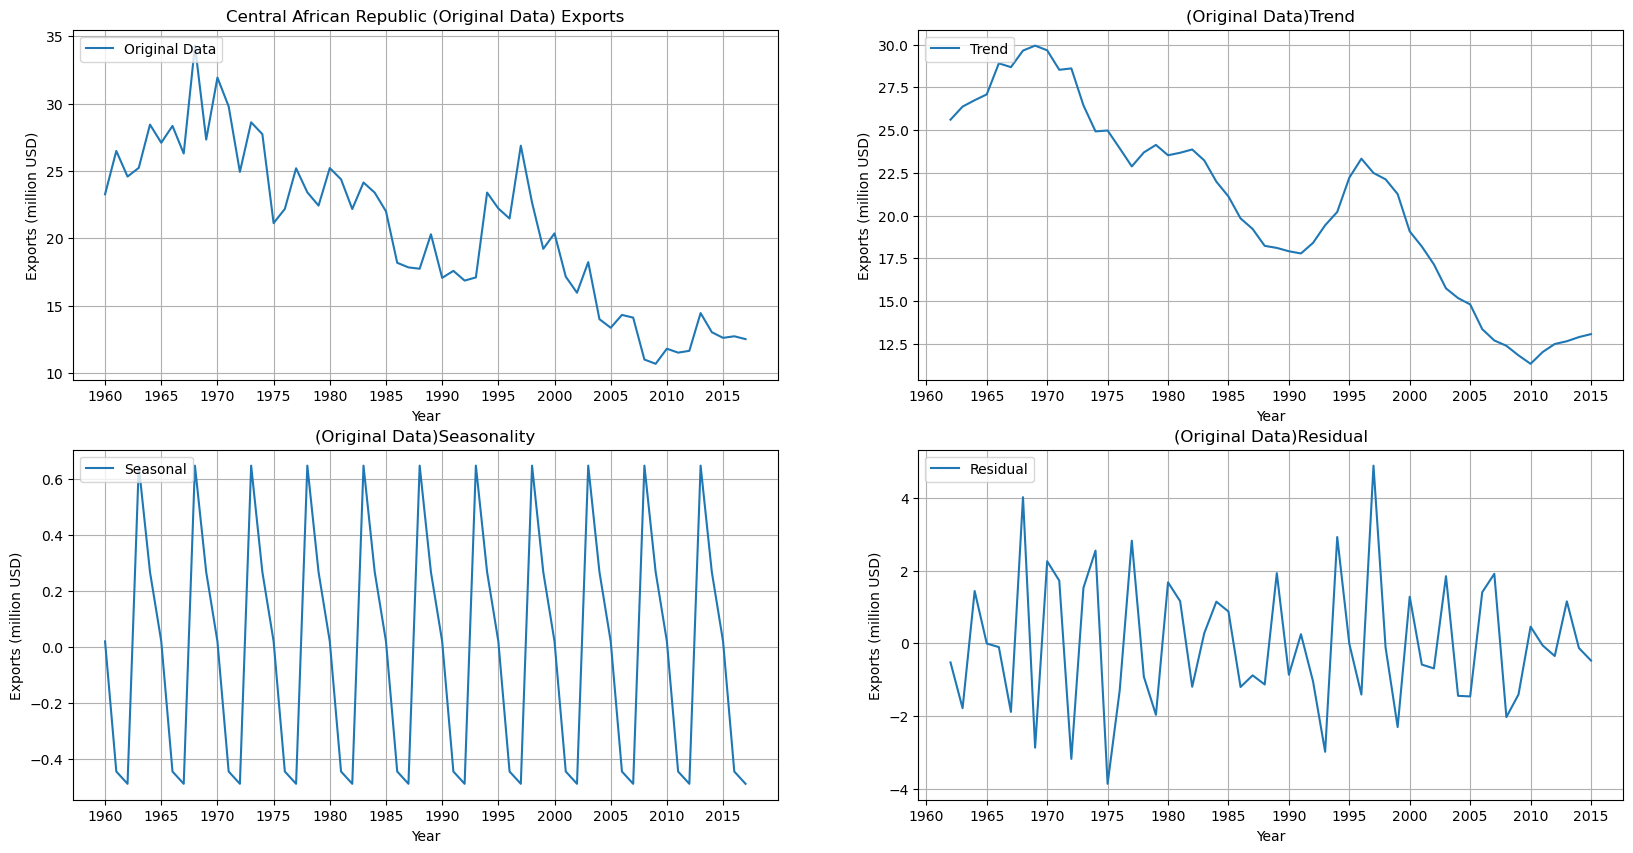

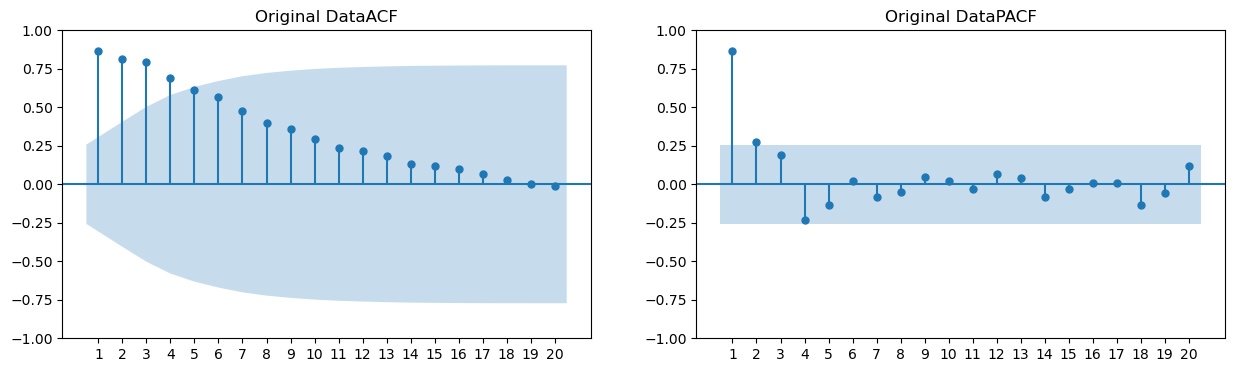

ADF Statistic: -0.8082410335269159
p-value: 0.8166893322999434
Since p value > 0.05, failed to reject H0: the Time Series is non-stationary.


In [196]:
visualize(df['Exports'], 'Original Data')
acf_pcf(df['Exports'], 'Original Data')

### Stationary Test
- since there is a decreasing trend, the time series might not be stationary
- Since the p value of ADF Test is high, we failed to reject H0, therefore the time series is `non-stationary`

### Insight

...

# Model Selection

### Transformation

#### Log Tranformation: Visuliazation, ACF, PACF

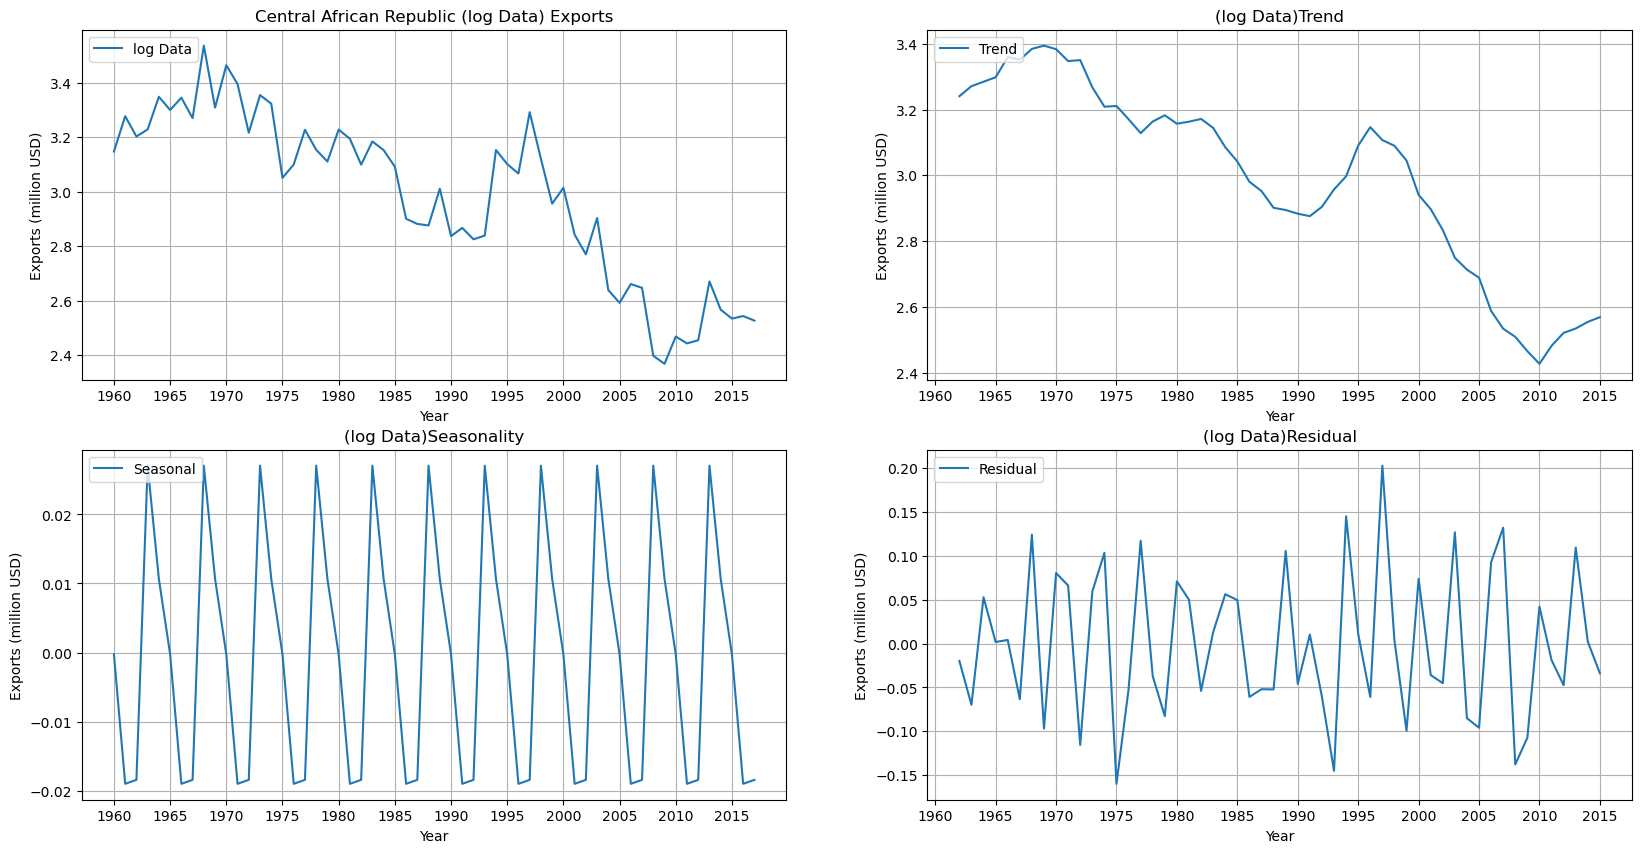

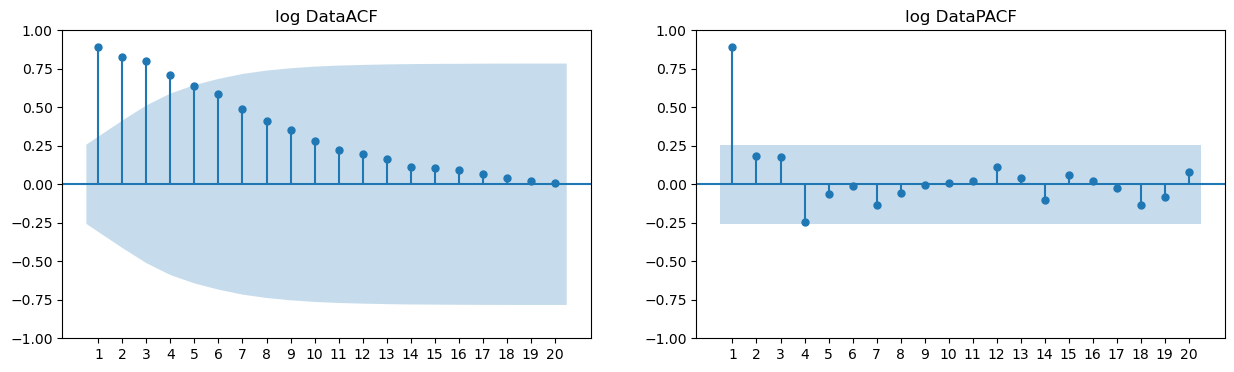

ADF Statistic: -0.7377150927705299
p-value: 0.8367371728631732
Since p value > 0.05, failed to reject H0: the Time Series is non-stationary.


In [197]:
df['log_Exports'] = np.log(df['Exports'])
visualize(df['log_Exports'], 'log Data')
acf_pcf(df['log_Exports'], 'log Data')


#### Box-Cox Tranformation: Visuliazation, ACF, PACF


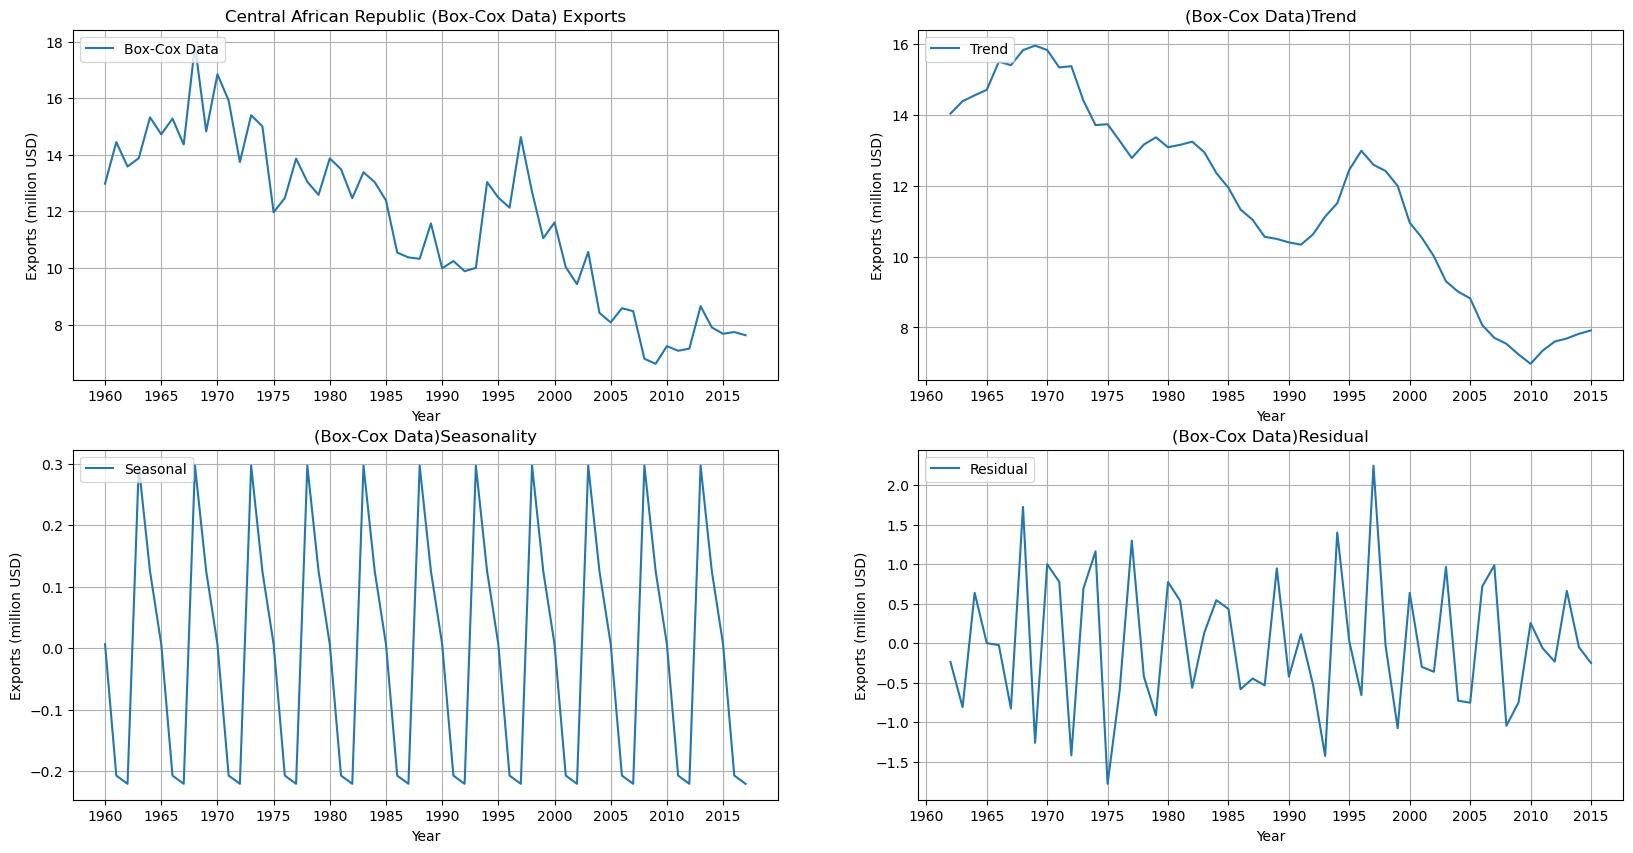

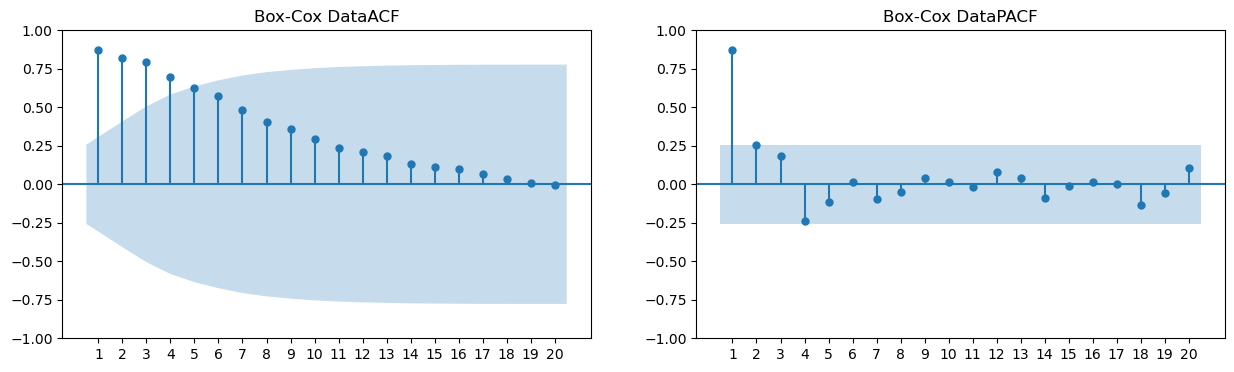

ADF Statistic: -0.788355894752384
p-value: 0.8225185297726014
Since p value > 0.05, failed to reject H0: the Time Series is non-stationary.


In [198]:
df['BoxCox_Exports'], best_lambda = boxcox(df['Exports'])
visualize(df['BoxCox_Exports'], 'Box-Cox Data')
acf_pcf(df['BoxCox_Exports'], 'Box-Cox Data')


Since none of the tranformations gave us stationary time series, we use take the difference on the originial data to keep it simple.

### original difference


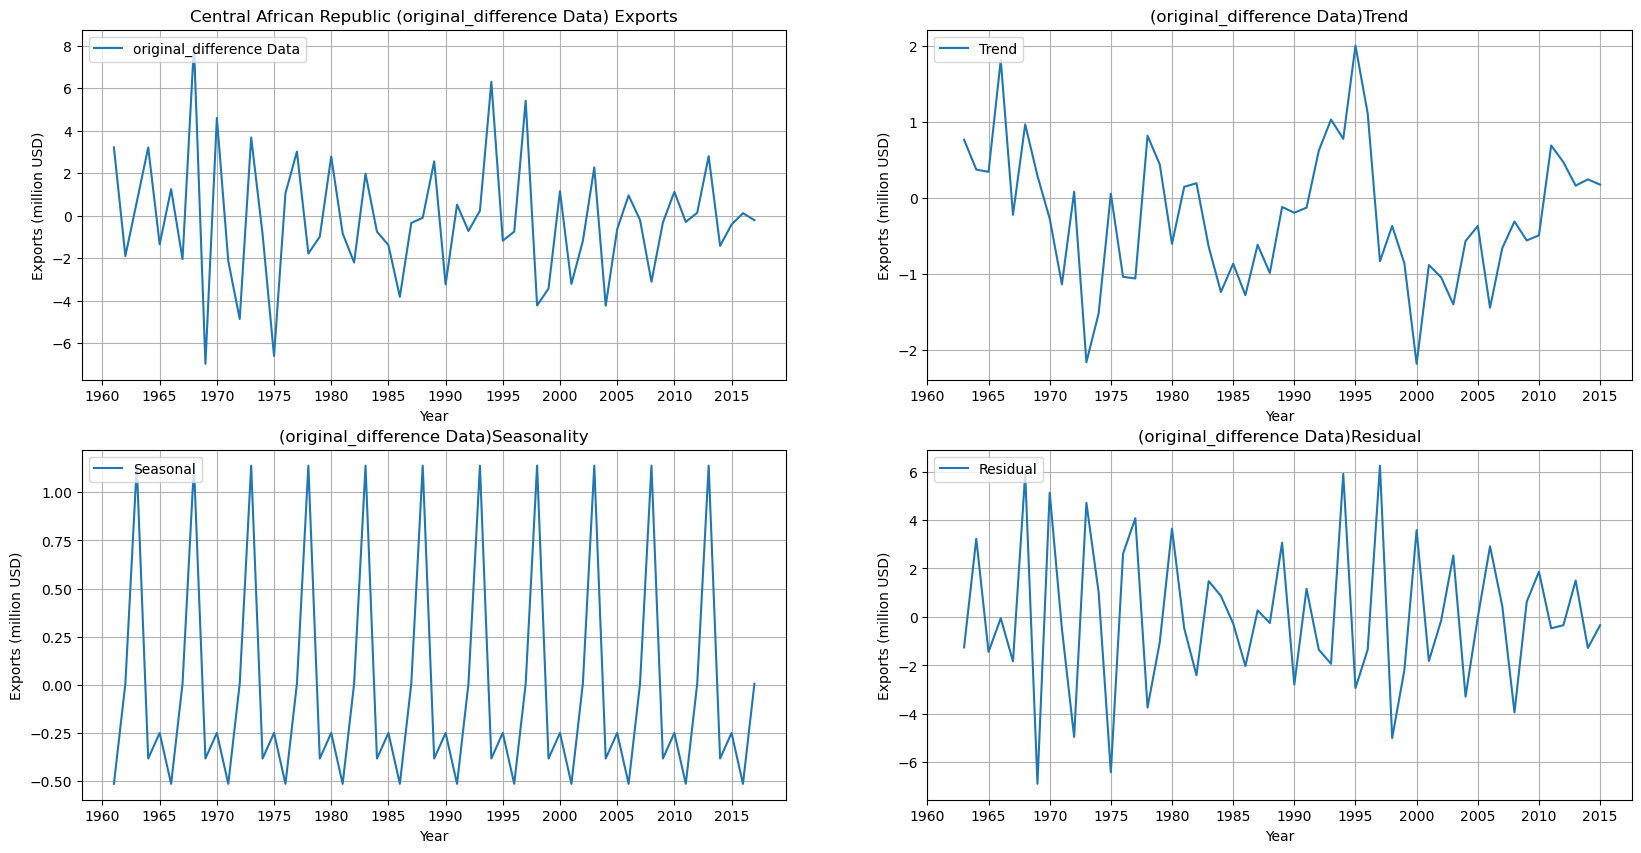

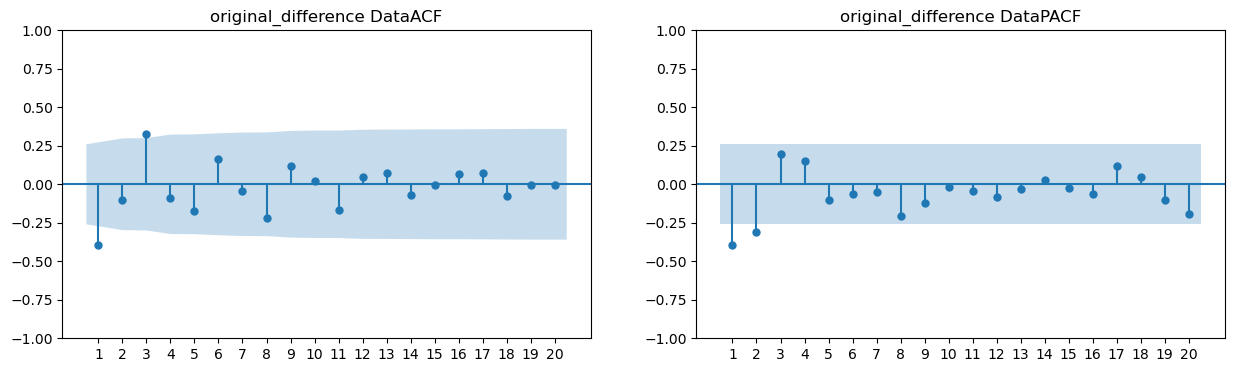

ADF Statistic: -4.429238597576829
p-value: 0.0002633943203133964
Since p value <= 0.05, rejected H0: the Time Series is stationary.


In [199]:
# take first order of difference
original_difference = df['Exports'].diff().dropna()
visualize(original_difference, 'original_difference Data')
acf_pcf(original_difference, 'original_difference Data')


The difference time series is `stationary`. good.

we may have MA(1) or AR(2) models from the ACF and PACF plots

### Finding Candidate Models

In [200]:
def report_perf(fitted_model, name):
    params = fitted_model.params
    pvalues = fitted_model.pvalues
    aic = fitted_model.aic
    bic = fitted_model.bic

    # print results
    print(f"\n{name} Model Parameters:")
    print(params)
    print(f"\n{name} Model P-values:")
    print(pvalues)
    print(f"\n{name} AIC: {aic}")
    print(f"\n{name} BIC: {bic}")

In [201]:
# we use original difference data
# MA(1)
ma1_model = ARIMA(df['Exports'], order=(0, 1, 1))  # AR=0, I=1, MA=1
ma1_fit = ma1_model.fit()
report_perf(ma1_fit, 'MA(1) Model')

# AR(2)
ar2_model = ARIMA(df['Exports'], order=(2, 1, 0))  # AR=2, I=1, MA=0
ar2_fit = ar2_model.fit()
report_perf(ar2_fit, 'AR(2) Model')



MA(1) Model Model Parameters:
ma.L1    -0.417225
sigma2    6.889319
dtype: float64

MA(1) Model Model P-values:
ma.L1     5.816893e-03
sigma2    4.467129e-10
dtype: float64

MA(1) Model AIC: 275.9580472710292

MA(1) Model BIC: 280.04414980669833

AR(2) Model Model Parameters:
ar.L1    -0.505033
ar.L2    -0.289666
sigma2    6.470776
dtype: float64

AR(2) Model Model P-values:
ar.L1     6.415884e-04
ar.L2     5.279816e-02
sigma2    7.184045e-09
dtype: float64

AR(2) Model AIC: 274.53688453198953

AR(2) Model BIC: 280.66603833549317


By selecting the values with cooresponding p value less than 0.05, we have the following models:

$$ y_t = x_t - x_{t-1} $$

 
where `xt` is the original data

#### MA(1)
$$ y_t = w_t - 0.417225 w_{t-1} $$

#### AR(2)
$$
y_t = -0.505033 y_{t-1} -0.289666 y_{t-2}+ w_t
$$


### Final Model

#### Define Function to Report Diagnosis

In [202]:
def diag(fitted_model, name, level=1):
    residuals = fitted_model.resid

    residuals = residuals[level:] # remove the first residual because we don't have data to predict the first term
                              # as we need the previous term to do the prediction
    
    standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Top-left: Time series plot of standardized residuals
    axes[0, 0].plot(standardized_residuals)
    axes[0, 0].set_title(f"{name} Standardized Residuals")
    axes[0, 0].set_xlabel("Time")
    axes[0, 0].set_ylabel("Residuals")

    # Bottom-left: ACF plot
    plot_acf(standardized_residuals, ax=axes[1, 0], lags=35, zero=False)
    axes[1, 0].set_title(f"{name} ACF of Residuals")

    # Top-right: Q-Q plot
    probplot(standardized_residuals, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title(f"{name} Normal Q-Q Plot of Std Residuals")

    # Bottom-right: Ljung-Box test p-values
    lags = 20  # Number of lags to check
    ljung_box = acorr_ljungbox(standardized_residuals, lags=lags, return_df=True)
    axes[1, 1].plot(ljung_box.index, ljung_box["lb_pvalue"], 'o-', label="p value")
    axes[1, 1].axhline(y=0.05, color='blue', linestyle='--', label="Significance Level (0.05)")
    axes[1, 1].set_title(f"{name} p values for Ljung-Box statistic")
    axes[1, 1].set_xlabel("LAG (H)")
    axes[1, 1].set_ylabel("p value")
    axes[1, 1].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()


#### MA(1)
$$ y_t = w_t - 0.417225 w_{t-1} $$

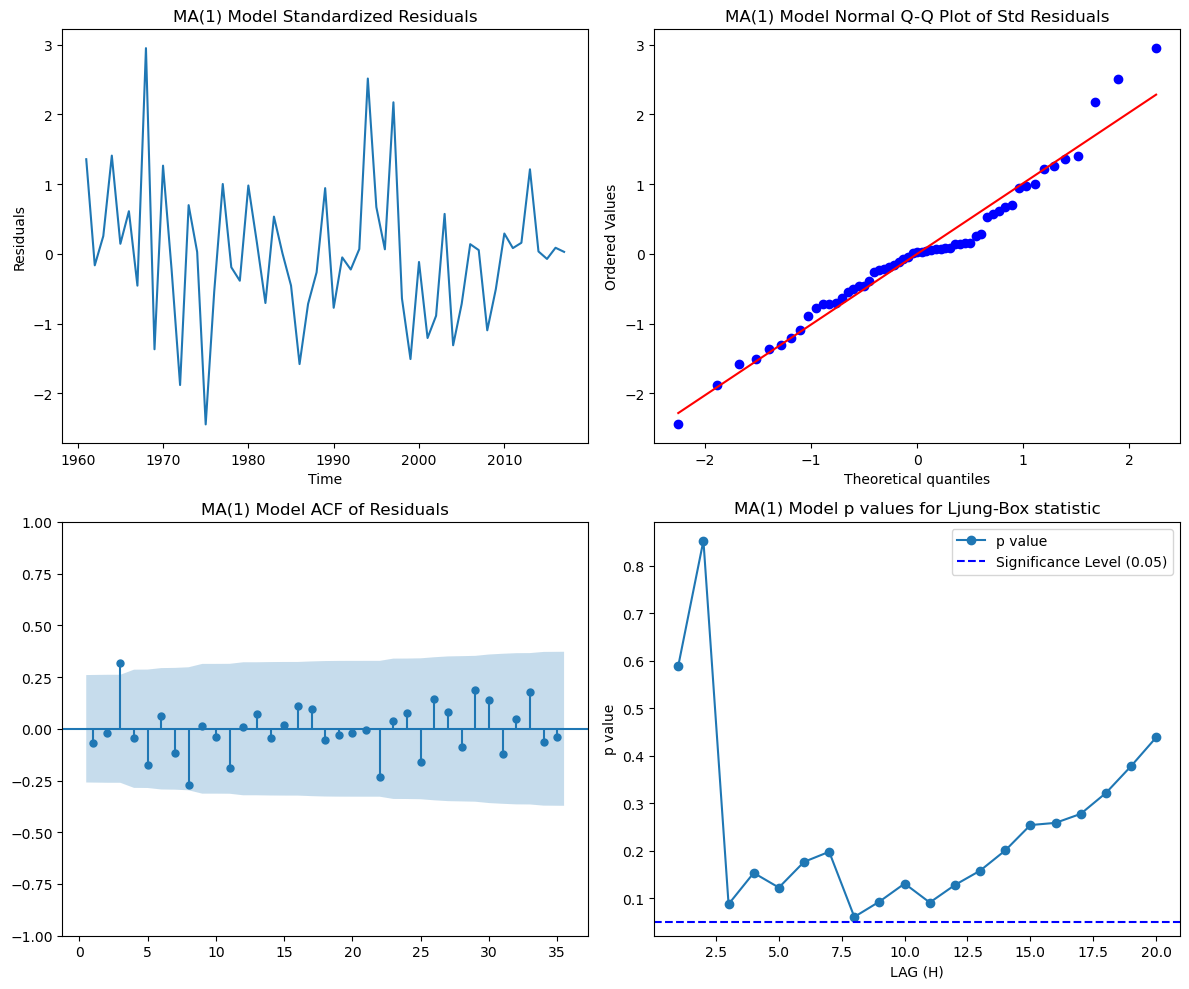

In [203]:
diag(ma1_fit, 'MA(1) Model')

Good, but not perfect

#### AR(2)
$$
y_t = -0.505033 y_{t-1} -0.289666 y_{t-2}+ w_t
$$

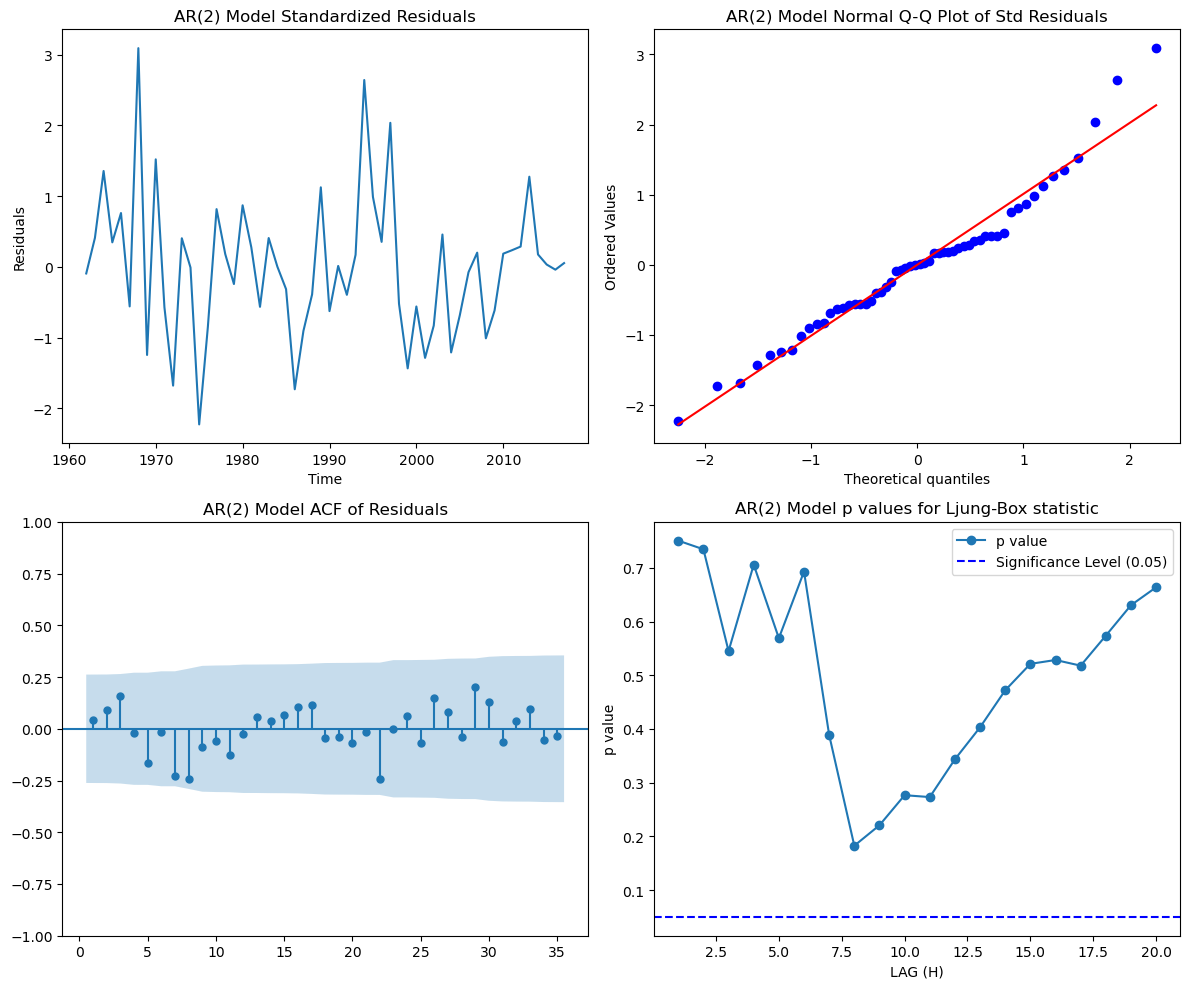

In [204]:
diag(ar2_fit, 'AR(2) Model', level=2) # we can only start at Residual3 because we need previous 2 data points to predict the third point

GOOD. we choose AR(2)

# Forecasting

### Define Functions

In [205]:
# Splitting the data into training and testing sets
train_size = int(len(df['Exports']) * 0.8)
train, test = df['Exports'][:train_size], df['Exports'][train_size:]

In [206]:
def calculate_MSE_Forecast_confi_int(data, ar_p, ar_i, ar_q):
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]
    model = ARIMA(train, order=(ar_p, ar_i, ar_q))
    model_fit = model.fit()

    forecast_result = model_fit.get_forecast(steps=len(test))
    forecast = forecast_result.predicted_mean
    conf_interval = forecast_result.conf_int()

    mse = mean_squared_error(test, forecast)
    return mse, forecast, conf_interval

In [207]:
def forecast_future(data, ar_p, ar_i, ar_q, steps=4, alpha=0.05):
    model = ARIMA(data, order=(ar_p, ar_i, ar_q))
    model_fit = model.fit()
    
    forecast_result = model_fit.get_forecast(steps=steps, alpha=alpha)
    forecast = forecast_result.predicted_mean
    conf_interval = forecast_result.conf_int()
    
    return forecast, conf_interval

In [208]:
def plot_test_prediction(prediction, conf_int, name, future_prediction=False):
    plt.figure(figsize=(12, 6))
    if future_prediction:
        plt.plot(df.index, df['Exports'], label='Historical Data', color='blue')
        future_index = pd.date_range(
                    start=df.index[-1] + pd.DateOffset(1),
                    periods=len(prediction),
                    freq='AS'
                )
        print('prediction:', prediction)
        plt.plot(future_index, prediction, label='Future Forecast', color='orange')
        plt.fill_between(
            future_index,
            conf_int.iloc[:, 0],
            conf_int.iloc[:, 1],
            color='orange',
            alpha=0.2,
            label='Confidence Interval'
        )
        plt.title(f'{name} 4 Steps Future Forecasting')
    else:  
        plt.plot(train.index, train, label='Train', color='blue')
        plt.plot(test.index, test, label='Test', color='green')
        plt.plot(test.index, prediction, label='Forecast', color='orange')
        plt.fill_between(
            test.index,
            conf_int.iloc[:, 0],
            conf_int.iloc[:, 1],
            color='orange',
            alpha=0.2,
            label='Confidence Interval'
        )
        plt.title(f'{name} Test Data Forecasting')
    plt.xlabel('Time')
    plt.ylabel('Exports')
    plt.legend()
    plt.grid(True)
    plt.show()


### Forecasting Test Data

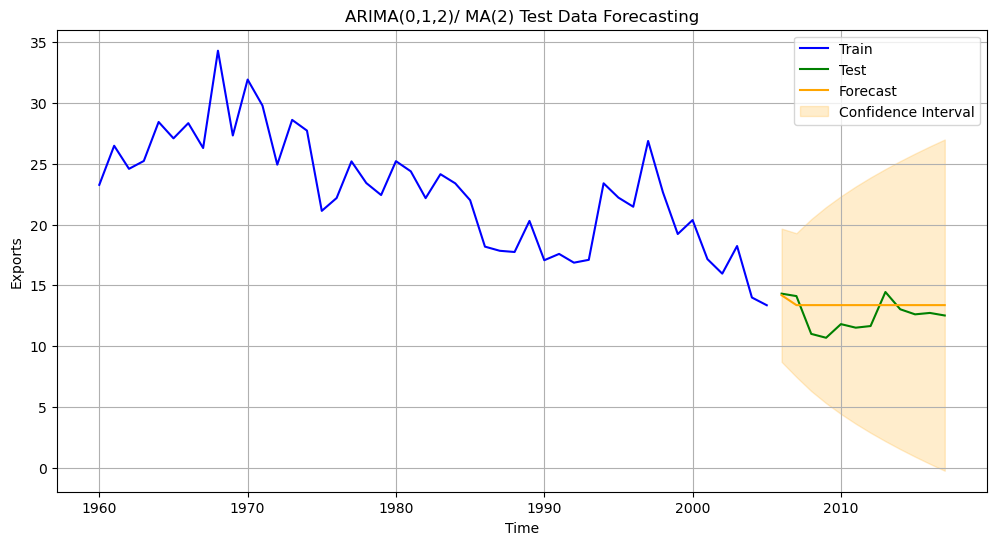

In [209]:
mse012, forecase012, confi_interal012 = calculate_MSE_Forecast_confi_int(df['Exports'], 0, 1, 2)
plot_test_prediction(forecase012,confi_interal012, 'ARIMA(0,1,2)/ MA(2)')

#### Forecasting Future Data (4 steps)

prediction: 2018-01-01    12.479463
2019-01-01    12.414773
2020-01-01    12.414773
2021-01-01    12.414773
Freq: AS-JAN, Name: predicted_mean, dtype: float64


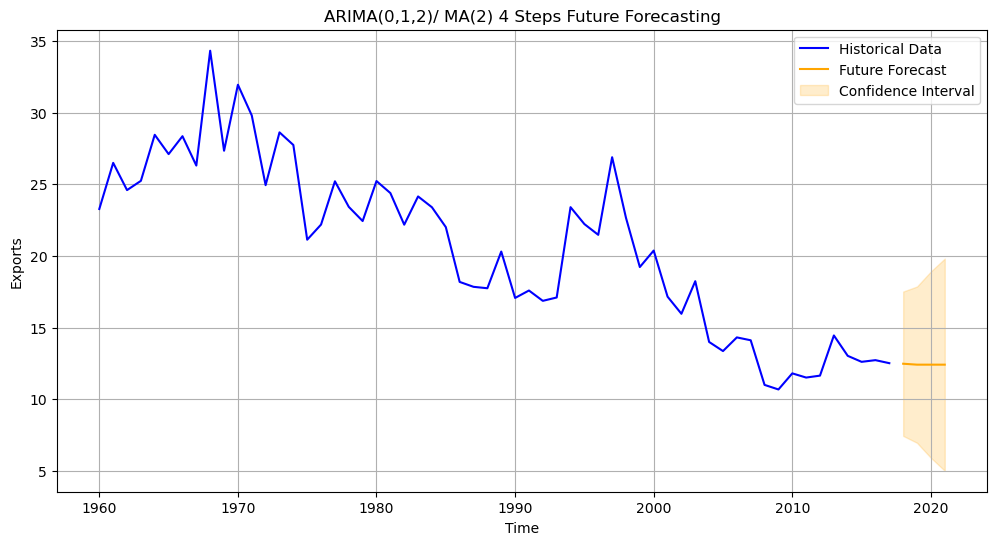

In [210]:
forecase_future012, confi_interal_future012 = forecast_future(df['Exports'], 0, 1, 2, steps=4)
plot_test_prediction(forecase_future012, confi_interal_future012, 'ARIMA(0,1,2)/ MA(2)', future_prediction=True)

# SPECIAL: Using MSE to Find the Best Model

In [211]:
# Defining the range of values for p and q
p_values = range(0, 10)
q_values = range(0,10)
i_values = range(0, 3)


# Initializing the variables to store the best model and its performance
best_mse = float('inf')
best_order = None
best_forecast = None
best_conf_interval = None


# Brute Force iterate all the combinations to find the best set of parameter
# Parameter tuning to find the best values of p, i, and q
for p in p_values:
    for q in q_values:
        for i in i_values:
            try:
                mse, forecast, conf_interval = calculate_MSE_Forecast_confi_int(df['Exports'], ar_p=p, ar_i=i, ar_q=q)

                # report MSE
                # print(f'ARIMA{(p, i, q)} model: MSE={mse}')

                # Updating the best model based on MSE
                if mse < best_mse:
                    best_mse = mse
                    best_order = (p, i, q)
                    best_forecast = forecast
                    best_conf_interval = conf_interval
                
            except Exception as e:
                print(f"Skipping (p={p}, q={q}) due to error: {e}")

# Printing the best model parameters
print(f'Best ARIMA model: order={best_order} with MSE = {best_mse}')


Best ARIMA model: order=(1, 1, 2) with MSE = 1.5950006989424645


This suggest that the ARIMA(1,1,2) model has the best performance.

Let's check the AIC and BIC of ARMA(1,1,2)

In [212]:
arma112 = ARIMA(df['Exports'], order=(1, 1, 2))
arma112_fit = arma112.fit()
report_perf(arma112_fit, 'ARIMA(1,1,2) Model')


ARIMA(1,1,2) Model Model Parameters:
ar.L1     0.337728
ma.L1    -0.883232
ma.L2     0.441870
sigma2    6.454815
dtype: float64

ARIMA(1,1,2) Model Model P-values:
ar.L1     4.120113e-01
ma.L1     1.861385e-02
ma.L2     3.300001e-03
sigma2    2.194527e-09
dtype: float64

ARIMA(1,1,2) Model AIC: 276.5109791837888

ARIMA(1,1,2) Model BIC: 284.683184255127


after removing the insignificant coefficient by p-value, we have a ARIMA(0,1,2) (on original data) model. 



Let's check the AIC and BIC to see if there's any improvement.

In [213]:
arma012 = ARIMA(df['Exports'], order=(0, 1, 2))
arma012_fit = arma012.fit()
report_perf(arma012_fit, 'ARIMA(0,1,2) Model')


ARIMA(0,1,2) Model Model Parameters:
ma.L1    -0.584707
ma.L2     0.287347
sigma2    6.596641
dtype: float64

ARIMA(0,1,2) Model Model P-values:
ma.L1     8.292635e-05
ma.L2     2.311155e-02
sigma2    1.804321e-09
dtype: float64

ARIMA(0,1,2) Model AIC: 275.69663363879636

ARIMA(0,1,2) Model BIC: 281.8257874423


Yes, both become lower.

But the MSE is higher:

In [214]:
mse012, _, _= calculate_MSE_Forecast_confi_int(df['Exports'], 0, 1, 2)
print(f'ARIMA{best_order}: MSE={best_mse}')
print(f'ARIMA(0, 1, 2): MSE={mse012}')

ARIMA(1, 1, 2): MSE=1.5950006989424645
ARIMA(0, 1, 2): MSE=2.106305219599589


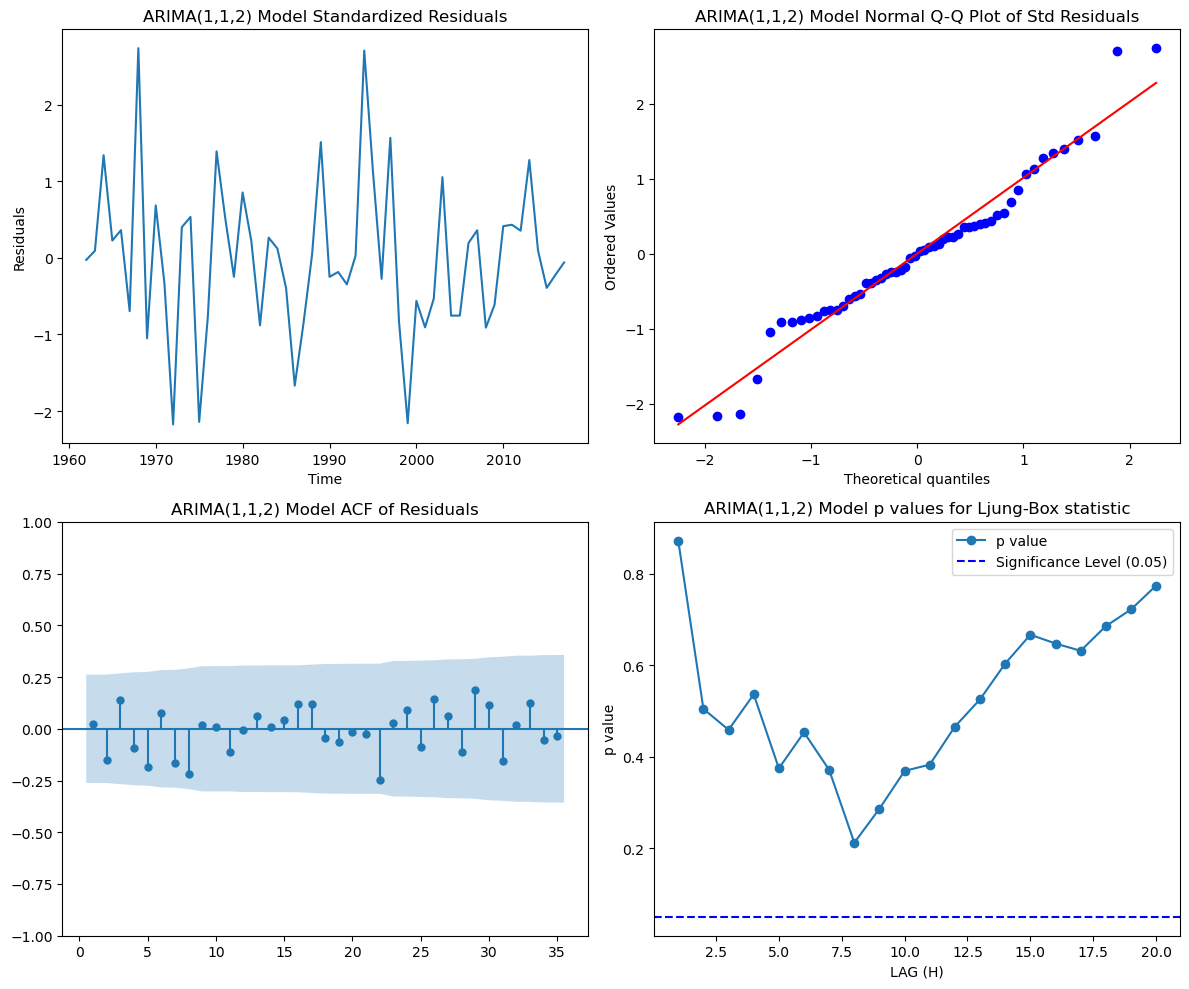

In [215]:
diag(arma112_fit, 'ARIMA(1,1,2) Model', level=2)

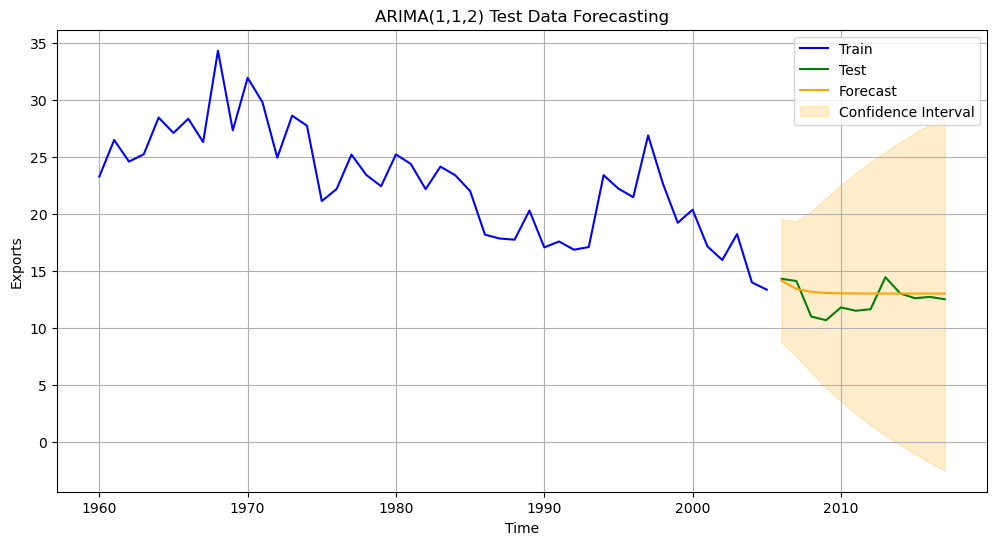

In [216]:
plot_test_prediction(best_forecast, best_conf_interval, 'ARIMA(1,1,2)')

prediction: 2018-01-01    12.457999
2019-01-01    12.244672
2020-01-01    12.172626
2021-01-01    12.148294
Freq: AS-JAN, Name: predicted_mean, dtype: float64


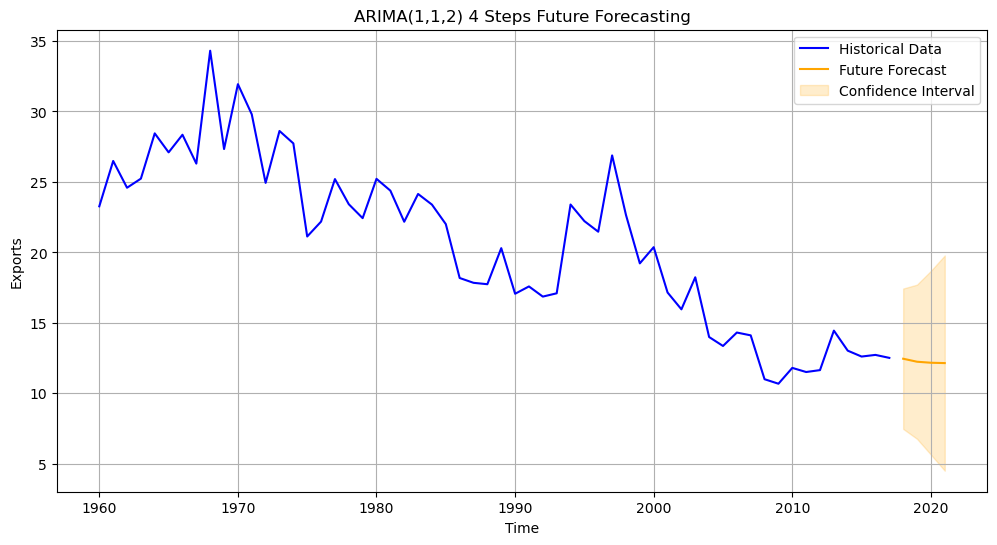

In [217]:
forecase_future112, confi_interal_future112 = forecast_future(df['Exports'], 1, 1, 2, steps=4)
plot_test_prediction(forecase_future112, confi_interal_future112, 'ARIMA(1,1,2)', future_prediction=True)